## Tuning the parameters for our find_peaks() algorithm
Using the analysis tools we've built, we want to tune the height and distance parameters for find_peaks to most accurately identify which are substantive meal intakes. Although there is no way of telling or infering via the one variable of COB what the intent has been behind a historic intake of carbohydrates, we know from previous texts (Cryer et al, 2009, Wiethop, Cryer, 1993) that an oral intake of glucose between 10-20g is a common recommended dose. Evidence shows that the glycaemic response may be transient and should be followed by a more substantial snack/meal within 2 hours.

Our time series COB data has well defined peaks and is distinctly lacking in noise. Therefore we look to set two parameters: height and distance. The height parameter will deterime the absolute number of grams of carbohydrate that someone has ingested allowing us to set a threshold around the amount of carbohydrates that we determine significant enough to consider in analysis. The distance parameter will help determine how close we allow peaks representing intake to be before we consider it as part of the same meal intake. Our find_peaks considers one step (at hour sample rate) as one hour. It does not accept floats, only integers. 

Therefore, our analysis will be based on peaks of carbohydrates around this range, thus suggesting our height parameter. Then we will consider our distance to be anything around 1 hour of this, (equating to a distance of 4 based on 15 minute samples). We will look at how this compares over ranges in these parameters.
$$\{sk  |  k \in [a..b]\}$$ 
(maths range notation - https://math.stackexchange.com/questions/2056510/what-is-the-mathematical-symbol-for-range)
$$\{\frac{1}{2}k  |  k \in [20..30]\}$$
h=15 +/- 5, and d=4 +/- 4 , to see the number of peaks this determines for each individual. This will use the following method:
1. Define a matrix of d and h value permutations
2. Process each individual with each permutation and build matrix of results
3. Aggregate the number of peaks per day by permutation, review the general distribution and investigate anomolies
4. Apply appropriate strategies to deal with anolomies
5. Select 

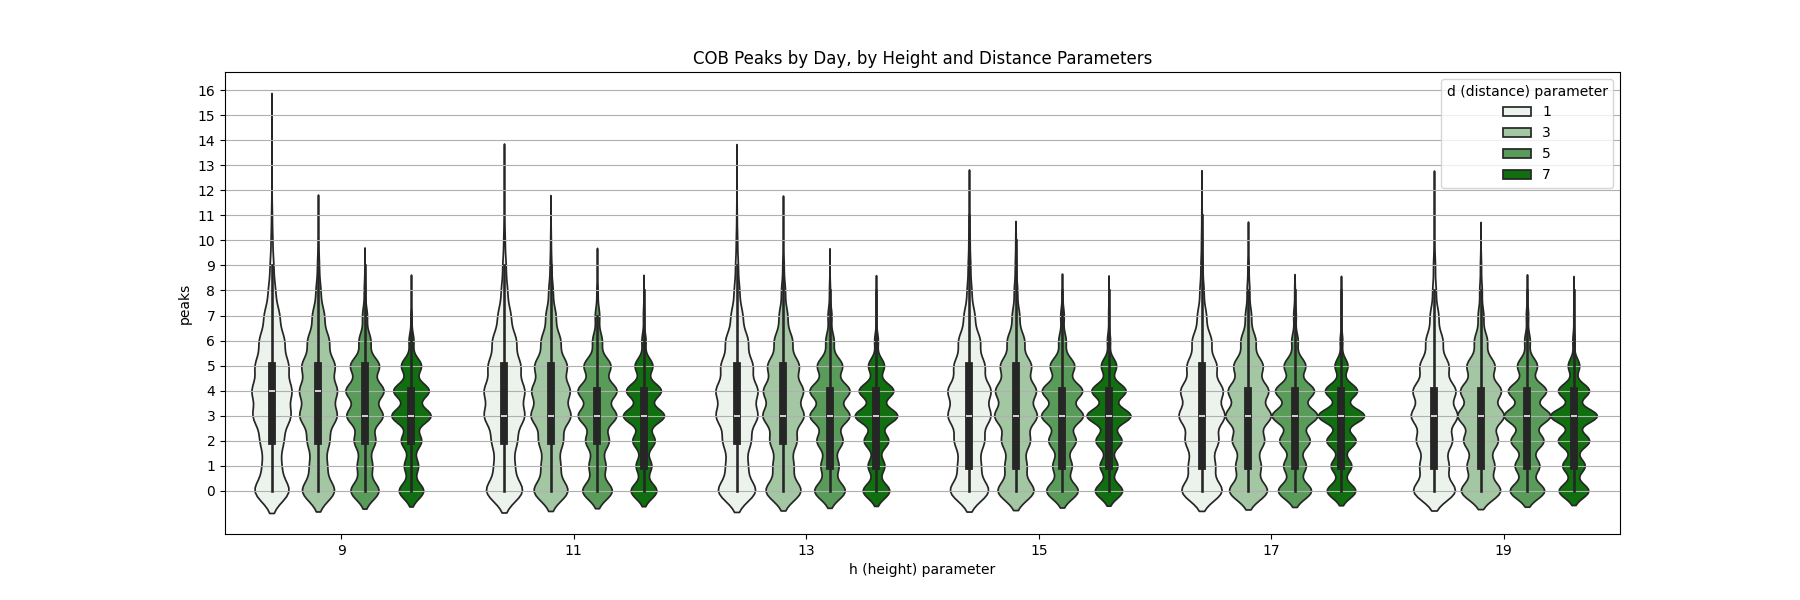

In [ ]:
# Create a dataframe of all possible combinations of height and distance
heights = np.arange(9,21,2)
distances = np.arange(1,8,2)
param_arrays = np.meshgrid(heights, distances)
data = {
    'h': param_arrays[0].flatten(),
    'd': param_arrays[1].flatten()
}
df_params = pd.DataFrame(data=data)

# # Create a dataframe to store the results of the experiment and produce the data
# df_params_exp = pd.DataFrame()

# for id in df_cob_interp['id'].drop_duplicates():
#     cob_indiv = df_cob_interp[df_cob_interp['id']==id].copy()
#     cob_indiv = cob_indiv.reset_index(names='datetime')
#     for i, r in df_params.iterrows():
#         peak_indices, _ = cob_peaks(ser=cob_indiv['cob max'], h=r['h'], d=r['d'])
#         cob_indiv['peaks'] = 0
#         cob_indiv.loc[peak_indices, 'peaks'] = 1
#         cob_indiv = cob_indiv.assign(id=id, h=r['h'], d=r['d'])
#         df_params_exp = pd.concat([df_params_exp, cob_indiv])

# df_params_exp.reset_index(drop=True, inplace=True)

# # Save the results of the experiment to a parquet file given the experiment is time-consuming
# df_params_exp.to_parquet(f_path + 'cob_peaks_exp.parquet')

df_params_exp = pd.read_parquet(f_path + 'cob_peaks_exp.parquet')

peaks_by_day = (df_params_exp[['id','day','h','d','peaks']]
                .groupby(['id','day','h','d'])
                .agg('sum'))

d_palette = sns.light_palette("green", as_cmap=True)
h_palette = sns.light_palette("blue", as_cmap=True)
def plot_peaks_by_day(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(18,6))
    sns.violinplot(data=df, x='h', y='peaks', hue='d', ax=ax, palette=d_palette)
    plt.title('COB Peaks by Day, by Height and Distance Parameters')
    plt.grid(axis='y')
    plt.xlabel('h (height) parameter')
    plt.yticks(range(0,17,1))
    plt.legend(title='d (distance) parameter')
    plt.show()

plot_peaks_by_day(peaks_by_day)

#### Zero-Peak Days
The plot shows that throughout the data there is a prevalence of days with zero meals intake. 24-hour fasting among people with T1D is highly unlikely yet it might be that some days for certain people, peaks may be removed the higher the parameter threshold, resulting in zero for that day. To discount any zero-peak days that might be due to data inconsistencies - such as missing data - we'll remove the instances where peaks do not exist for the parameters set at the lowest threshold of h=9, d=1. First, lets look at the number of zero-peak days in the analysis, relative to the different parameters.

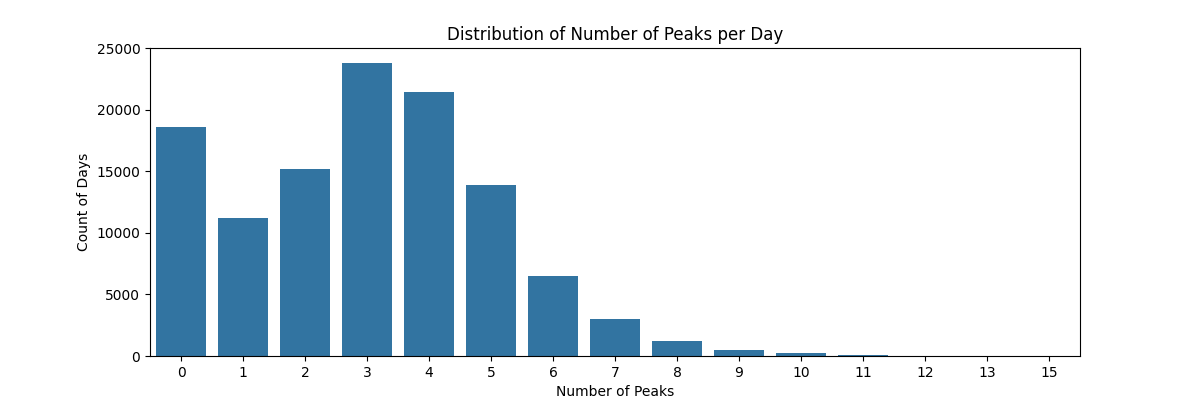

In [ ]:
peaks_count = peaks_by_day.groupby(['peaks'])['peaks'].count()
plt.figure(figsize=(12,4))
sns.barplot(x=peaks_count.index, y=peaks_count.values)
plt.xlabel('Number of Peaks')
plt.ylabel('Count of Days')
plt.title('Distribution of Number of Peaks per Day')
plt.show()


Number of days with no peaks at h=9 and d=1: 735
Length of original dataset: 115680
Length of dataset with zero-peak days removed: 98040


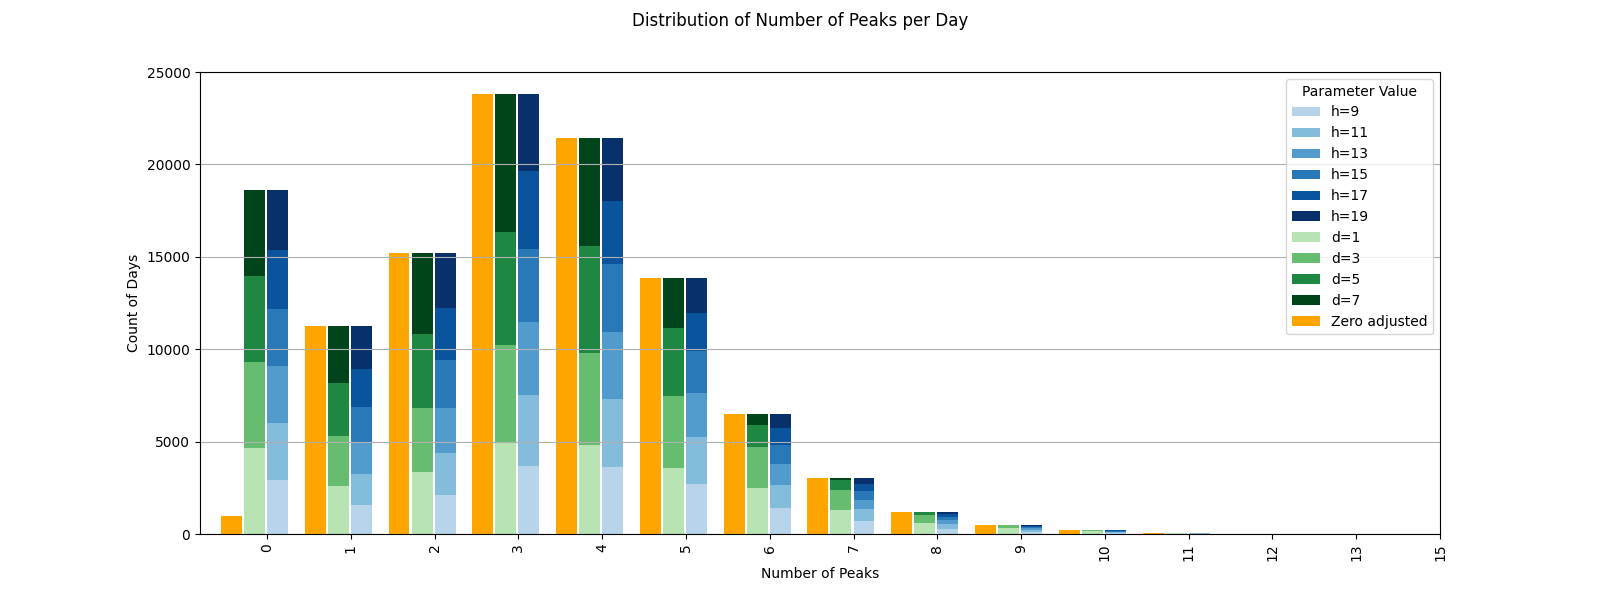

In [ ]:
peaks_by_day_reset = peaks_by_day.reset_index().set_index(['id','day'])

blues = plt.get_cmap('Blues')
h_colours = LinearSegmentedColormap.from_list('custom_blues', blues(np.linspace(0.3, 1, 256)))
peaks_by_h = (peaks_by_day_reset
              .groupby(['h','peaks'])
              .agg(count=('h','count'))
              .reset_index()
              .pivot(index='peaks', columns='h', values='count')
              .fillna(0))

greens = plt.get_cmap('Greens')
d_colours = LinearSegmentedColormap.from_list('custom_greens', greens(np.linspace(0.3, 1, 256)))
peaks_by_d = (peaks_by_day_reset
              .groupby(['d','peaks'])
              .agg(count=('d','count'))
              .reset_index()
              .pivot(index='peaks', columns='d', values='count')
              .fillna(0))

zero_peak_days = peaks_by_day_reset[(peaks_by_day_reset['peaks']==0) 
                   & (peaks_by_day_reset['h']==9) 
                   & (peaks_by_day_reset['d']==1)]
print(f'Number of days with no peaks at h=9 and d=1: {len(zero_peak_days)}')

peaks_zero_adjusted = peaks_by_day_reset.drop(index=zero_peak_days.index)
print(f'Length of original dataset: {len(peaks_by_day_reset)}')
print(f'Length of dataset with zero-peak days removed: {len(peaks_zero_adjusted)}')
zero_adjusted_grouped = peaks_zero_adjusted.groupby(['peaks'])['peaks'].count()

# Plotting the distribution of peaks by height and distance parameters, against that of zero-peak days adjusted for h=9 and d=1
fig, ax = plt.subplots(figsize=(16, 6))
bar_width = 0.25
bars_h = peaks_by_h.plot(kind='bar', stacked=True, colormap=h_colours, position=0, width=bar_width, ax=ax)
bars_d = peaks_by_d.plot(kind='bar', stacked=True, colormap=d_colours, position=1.1, width=bar_width, ax=ax)
bars_zero = zero_adjusted_grouped.plot(kind='bar', stacked=True, position=2.2, width=bar_width, color='orange', ax=ax)
ax.set_xlabel('Number of Peaks')
ax.grid(axis='y')
ax.set_ylabel('Count of Days')
legend_labels = ['h=9','h=11','h=13','h=15','h=17','h=19', 'd=1','d=3','d=5','d=7','Zero adjusted']
ax.legend(title='Parameter Value', loc='upper right', labels=legend_labels)
fig.suptitle('Distribution of Number of Peaks per Day')
plt.show()

The orange bars show the distribution having made the adjustment for zero-peak days. This further highlights a potential anomoly whereby the prevalence of 1-peak days may not reflect the underlying distribution. We would expect few instances of days in which carbohydrate intake exceeding 9g to only happen once. However, it is difficult to understand the underlying cause without better understanding the data capture method and behaviours. It may be that we need to impute data to reflect the distribution, but before we make this decision, lets focus on selecting the parameters and producing our final dataset of peaks-by-day to work with. First, we repeat our prior analysis with the zero-peak adjusted data.

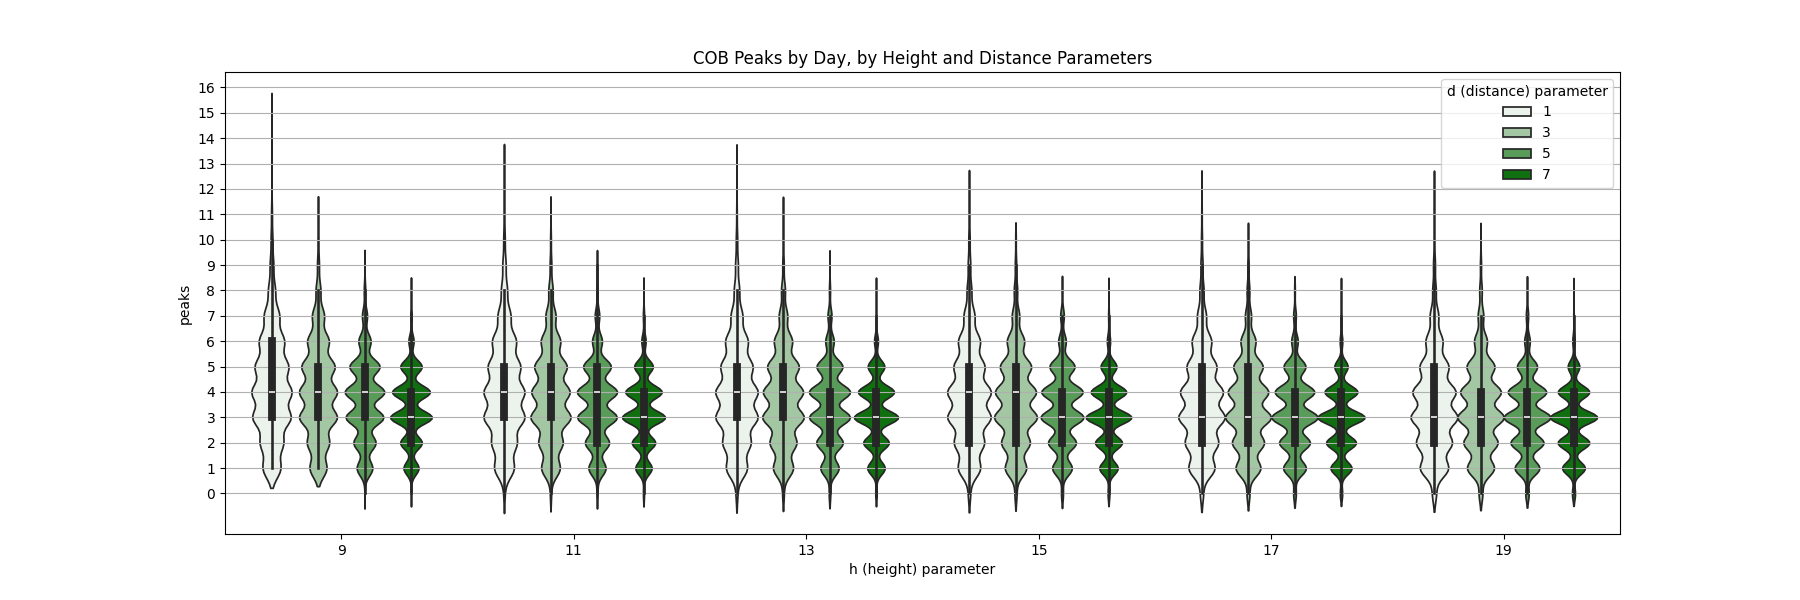

peaks                         
          mean       std min max    sum
h  d                                   
9  1  4.269523  2.058656   1  15  17441
   3  4.076867  1.883083   1  11  16654
   5  3.677111  1.570036   0   9  15021
   7  3.347124  1.347884   0   8  13673
11 1  4.093513  2.035091   0  13  16722
   3  3.909180  1.863045   0  11  15969
   5  3.532191  1.558445   0   9  14429
   7  3.227173  1.347830   0   8  13183
13 1  3.961567  1.996506   0  13  16183
   3  3.783109  1.826178   0  11  15454
   5  3.427907  1.535574   0   9  14003
   7  3.139290  1.331983   0   8  12824
15 1  3.863647  1.965985   0  12  15783
   3  3.688617  1.797125   0  10  15068
   5  3.347368  1.511309   0   8  13674
   7  3.073929  1.314955   0   8  12557
17 1  3.668788  1.925070   0  12  14987
   3  3.502570  1.758930   0  10  14308
   5  3.184578  1.483572   0   8  13009
   7  2.934884  1.298183   0   8  11989
19 1  3.546144  1.904847   0  12  14486
   3  3.386781  1.742121   0  10  13835
   5  3.081273  1.472488   0   8  12587
   7  2.846512  1.293278   0   8  11628

In [ ]:
plot_peaks_by_day(peaks_zero_adjusted)

peaks_zero_adjusted_summary = (peaks_zero_adjusted
 .groupby(['h','d'])
 .agg({'peaks':['mean','std','min','max','sum']}))

display(peaks_zero_adjusted_summary)

Based on visual inspection, the initial assumptions around the best choice for distance appears somewhat validated by the data. At a distance of under 5 we see a significant spread of peaks, with ranges becoming more within the expected range as we exceed 4. The deviation becomes more limited but the mean is dropping too close to (and below) 3 peak per day at h > 13. We will continue for now with d=5 and look more closely at height. 

In [ ]:
peaks_at_d5 = peaks_zero_adjusted[peaks_zero_adjusted['d']==5]
display(peaks_at_d5.head())

h  d  peaks
id      day                     
4762925 2017-10-13   9  5      1
        2017-10-13  11  5      1
        2017-10-13  13  5      1
        2017-10-13  15  5      1
        2017-10-13  17  5      1

peaks                         
          mean       std min max    sum
h  d                                   
9  5  3.677111  1.570036   0   9  15021
11 5  3.532191  1.558445   0   9  14429
13 5  3.427907  1.535574   0   9  14003
15 5  3.347368  1.511309   0   8  13674
17 5  3.184578  1.483572   0   8  13009
19 5  3.081273  1.472488   0   8  12587

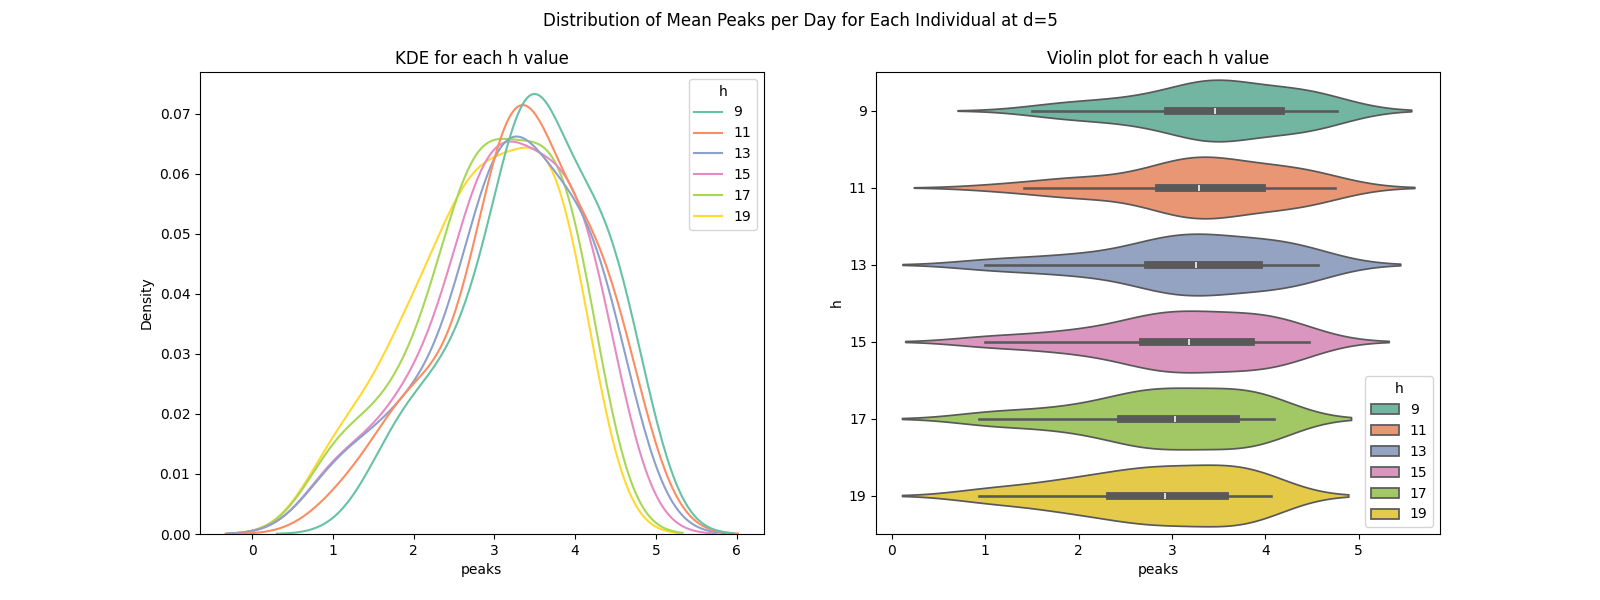

In [ ]:
h_means = peaks_at_d5.groupby(['id','h']).agg({'peaks':'mean'}).reset_index().set_index('id')

display(peaks_zero_adjusted_summary.loc[(slice(None), 5), :])

fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
sns.kdeplot(data=h_means, x='peaks', hue='h', palette='Set2', ax=ax[0])
ax[0].set_title('KDE for each h value')
ax[1].set_title('Violin plot for each h value')
sns.violinplot(data=h_means, x='peaks', y='h', hue='h', palette='Set2', ax=ax[1], orient='h')
fig.suptitle('Distribution of Mean Peaks per Day for Each Individual at d=5')
plt.show()

There is little difference between the outcomes of each height parameter value that we will continue with h=15. There will be an opportunity to test the accuracy of a model furter on with the chosen parameters for accuracy.

### High Peak-Count Outliers

Though there are days in which an excess of 6 peaks are counted, we mustn't discount these as they may be valid. It is less possible to challenge the circumstances of outliers amongst these, though it might be worth looking at some of the extreme examples to see if there are patterns or salient issues that appear. We'll do so using our sample of COB on days with high peaks at our chosen (h,d).

In [ ]:
peaks_d5_h15 = peaks_zero_adjusted[(peaks_zero_adjusted['h']==15) & (peaks_zero_adjusted['d']==5)].drop(columns=['h','d'])
high_max_people = peaks_d5_h15.groupby(['id']).agg({'peaks':['mean', 'count', 'min','max']}).sort_values(('peaks','max'), ascending=False).head()
display(high_max_people)

peaks              
              mean count min max
id                              
13783771  4.226804    97   1   8
17161370  3.623288   146   0   8
14092221  3.996255   534   1   8
32997134  4.246154    65   0   8
74077367  3.986264   364   0   8

In [ ]:
def filter_date_range(df: pd.DataFrame, from_date: str, to_date: str):
    df['day'] = df.index.strftime('%Y-%m-%d')
    df_filtered = df[(df['day'] >= from_date) & (df['day'] <= to_date)]
    return df_filtered.drop(columns='day')

subject = 13783771
cob_indiv = cob_individual(df, subject)
peak_indices,properties = cob_peaks(cob_indiv['cob max'], h=15, d=5)

indiv_high_peaks_per_day = (peaks_zero_adjusted.loc[subject]
                            .query('h==15 & d==5')
                            .sort_values('peaks', ascending=False)
                            .head(5))
print(f'The following are the max peaks for individual {subject}')
display(indiv_high_peaks_per_day)

from_date = indiv_high_peaks_per_day.index[0].strftime('%Y-%m-%d')
print(from_date)
to_date = from_date
cob_indiv_filtered = filter_date_range(cob_indiv, from_date, to_date)
cob_indiv_filtered

The following are the max peaks for individual 13783771


,h,d,peaks
day,,,
2017-04-27,15,5,8
2017-05-01,15,5,8
2017-04-22,15,5,8
2017-03-04,15,5,7
2017-04-29,15,5,7


2017-04-27


,cob max
datetime,
2017-04-27 00:00:00+00:00,10.0
2017-04-27 00:30:00+00:00,1.0
2017-04-27 00:45:00+00:00,96.0
2017-04-27 01:00:00+00:00,95.0
2017-04-27 01:15:00+00:00,90.0
...,...
2017-04-27 22:30:00+00:00,10.0
2017-04-27 22:45:00+00:00,14.0
2017-04-27 23:00:00+00:00,16.0
